In [1]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from keras.optimizers      import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24
# the scope of the LSTM Model
stations = 66

# convert an array of values into a dataset matrix, adjusted to make a dateset that is 66 wide
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        # Makes sure that the array isn't the last 2 or 3 or whatever bits. It has to be the full 24
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a.T)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, :].T)
    return np.array(dataX), np.array(dataY)

def predict_with_uncertainty(model, dataset, n_iter=100):
    # This function activates drop-out when doing predictions
    f = K.function([model.layers[0].input, K.learning_phase()],
                      [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (stations,look_forward,) )

    for iter in range(n_iter):
        all_pred[iter] = np.array( f([dataset.reshape( (1,) + dataset.shape), 1]) ).reshape(66, 24)
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

# given a model and data from the original dataset, it uses predict_with_uncertainty to predict with dropout
def run_predictions (model, dataset):

    # scale the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(np.array(dataset))
    data = dataset.T

    # feeds the model and data into a function that will activate the dro-out
    all_pred, avg_pred, std = predict_with_uncertainty(model, data)
    # All the predictions
    for i in range(all_pred.shape[0]):
        for j in range(all_pred.shape[2]):
            all_pred[i,:,j] = scaler.inverse_transform(all_pred[i,:,j].reshape(1,-1))
    for i in range(look_forward):
        # The Average Prediction
        avg_pred[:,i] = scaler.inverse_transform(avg_pred[:,i].reshape(1,-1))
        # The Standard Deviation At Each T Of Prediction
        std[:,i] = scaler.inverse_transform(std[:,i].reshape(1,-1))

    return all_pred, avg_pred, std

Using TensorFlow backend.


In [2]:
def predict (model, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    
    temp = rcParams['figure.figsize']
    rcParams['figure.figsize'] = 15, 3
    
    # creates matrices to hold the 
    avg_preds = np.zeros((288*total_days/delta, stations, look_forward))
    true_vals = np.zeros((288*total_days/delta, stations, look_forward))
    cdf_vals  = np.zeros((288*total_days/delta, stations, look_forward))

    percent_over     = np.zeros(288*total_days/delta)
    percent_negative = np.zeros(288*total_days/delta)
    
    # Runs all the predictions
    for i in range (288*total_days/delta):
        
        # the point where the model will predict
        point = 288*day + i * delta

        # Gets predictions
        all_pred, avg_pred, std = run_predictions (model, dataset_orig[point-look_back:point])
        # Gets the True Values
        true_val = dataset_orig[point:point+look_forward,:].T
        
        percent_negative[i] = 100.0 * (all_pred < 0).sum() / all_pred.size
        
        # converts the original values to cdf values according to the cumullative distibution functions at t+1, t+2, ..., t+24 (0.0-1.0)
        # Adds the values to the overall matrix of cdf
        cdf_vals[i,:,:] = norm.cdf(true_val, loc=avg_pred, scale=std)

        avg_preds[i], true_vals[i] = avg_pred, true_val

        if(show_graph):
            for i in np.arange(stations):
                plt.figure(i)
                
                # plots the uncertainty to the degree of half a standard deviation
                plt.fill_between(range(point, point+look_forward), 
                                 avg_pred[i] + std[i]/2.0, 
                                 avg_pred[i] - std[i]/2.0, 
                                 facecolor='red', alpha=0.25)
                # plots the uncertainty to the degree of a full standard deviation
                plt.fill_between(range(point, point+look_forward), 
                                 avg_pred[i] + std[i], 
                                 avg_pred[i] - std[i], 
                                 facecolor='red', alpha=0.25)
                # plots the average predictions
                plt.plot(range(point, point+look_forward), avg_pred[i], color='red', alpha=1)

    print "Percent Negative: {}".format(np.mean(percent_negative))

    if show_graph:
        for i in range (stations):
            plt.figure(i)
            plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,i])
            plt.axhline(0)
        plt.show()

    if show_gradual_error:
        indiv_err = true_vals - avg_preds
        for i in range(look_forward):
            plt.scatter(np.ones(len(indiv_err[:,i]))*i,indiv_err[:,i], color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        
    rcParams['figure.figsize'] = temp
    
    return cdf_vals


In [3]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
# dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)
dataframe = dataframe.groupby('day_hour').sum()
# removes the timestamp at column 67
dataset_orig = dataframe.values[:,:stations]
dataset_orig = dataset_orig.astype('float32')
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)


In [4]:
# split into train and test sets
train_size = 288 * 10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

In [8]:
# creates a model but does not compile the model
def create_model(rate=0.3):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(stations, look_back)))
    lstm = LSTM(256, recurrent_dropout=0.3, return_sequences=True)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(look_forward))
    return model

In [9]:
def priorities (y_true, y_pred):
    w = np.arange(1,0, -1./24)**1.3
    w = w / w.sum()
    w = w[:,None]
    W = K.variable(value = w)
    return K.dot( K.abs(y_pred-y_true), W)

batch = 1
seed = 11
# create and fit the LSTM network
model = create_model(rate=0.3)

np.random.seed(seed)
model.compile(loss=priorities, optimizer=RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0))
model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)

# cdf_matrix = predict(model, total_days=1,day=11,delta=1, show_graph=False)
# for i in range (24):
#     plt.hist(cdf_matrix[:,i],20)
#     plt.show()

Epoch 1/60
7s - loss: 0.1680
Epoch 2/60
7s - loss: 0.1202
Epoch 3/60
7s - loss: 0.1027
Epoch 4/60
7s - loss: 0.0931
Epoch 5/60
7s - loss: 0.0872
Epoch 6/60
7s - loss: 0.0834
Epoch 7/60
7s - loss: 0.0808
Epoch 8/60
7s - loss: 0.0790
Epoch 9/60
7s - loss: 0.0775
Epoch 10/60
7s - loss: 0.0763
Epoch 11/60
7s - loss: 0.0755
Epoch 12/60
7s - loss: 0.0746
Epoch 13/60
7s - loss: 0.0741
Epoch 14/60
7s - loss: 0.0734
Epoch 15/60
7s - loss: 0.0731
Epoch 16/60
7s - loss: 0.0727
Epoch 17/60
7s - loss: 0.0722
Epoch 18/60
7s - loss: 0.0719
Epoch 19/60
7s - loss: 0.0717
Epoch 20/60
7s - loss: 0.0714
Epoch 21/60
7s - loss: 0.0712
Epoch 22/60
7s - loss: 0.0709
Epoch 23/60
7s - loss: 0.0706
Epoch 24/60
7s - loss: 0.0705
Epoch 25/60
7s - loss: 0.0703
Epoch 26/60
7s - loss: 0.0701
Epoch 27/60
7s - loss: 0.0701
Epoch 28/60
7s - loss: 0.0699
Epoch 29/60
7s - loss: 0.0697
Epoch 30/60
7s - loss: 0.0695
Epoch 31/60
7s - loss: 0.0694
Epoch 32/60
7s - loss: 0.0694
Epoch 33/60
7s - loss: 0.0692
Epoch 34/60
7s - lo

In [25]:
model.fit(trainX, trainY, epochs=60, batch_size=60, verbose=2)

Epoch 1/60
7s - loss: 0.0654
Epoch 2/60
7s - loss: 0.0655
Epoch 3/60
7s - loss: 0.0654
Epoch 4/60
7s - loss: 0.0653
Epoch 5/60
7s - loss: 0.0653
Epoch 6/60
7s - loss: 0.0653
Epoch 7/60
7s - loss: 0.0652
Epoch 8/60
7s - loss: 0.0653
Epoch 9/60
7s - loss: 0.0652
Epoch 10/60
7s - loss: 0.0651
Epoch 11/60
7s - loss: 0.0651
Epoch 12/60
7s - loss: 0.0651
Epoch 13/60
7s - loss: 0.0650
Epoch 14/60
7s - loss: 0.0650
Epoch 15/60
7s - loss: 0.0649
Epoch 16/60
7s - loss: 0.0650
Epoch 17/60
7s - loss: 0.0650
Epoch 18/60
7s - loss: 0.0649
Epoch 19/60
7s - loss: 0.0649
Epoch 20/60
7s - loss: 0.0648
Epoch 21/60
7s - loss: 0.0648
Epoch 22/60
7s - loss: 0.0648
Epoch 23/60
7s - loss: 0.0648
Epoch 24/60
7s - loss: 0.0647
Epoch 25/60
7s - loss: 0.0647
Epoch 26/60
7s - loss: 0.0648
Epoch 27/60
7s - loss: 0.0647
Epoch 28/60
7s - loss: 0.0646
Epoch 29/60
7s - loss: 0.0646
Epoch 30/60
7s - loss: 0.0647
Epoch 31/60
7s - loss: 0.0645
Epoch 32/60
7s - loss: 0.0646
Epoch 33/60
7s - loss: 0.0646
Epoch 34/60
7s - lo

Percent Negative: 7.94736952862


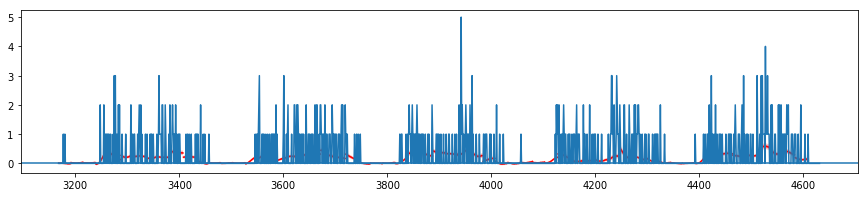

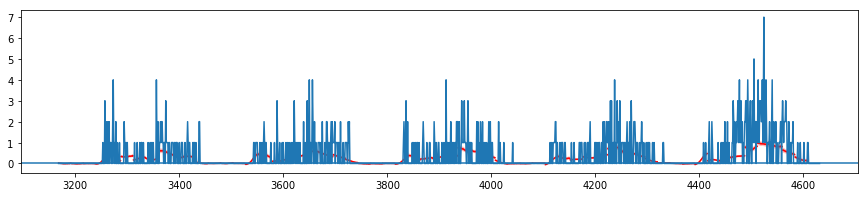

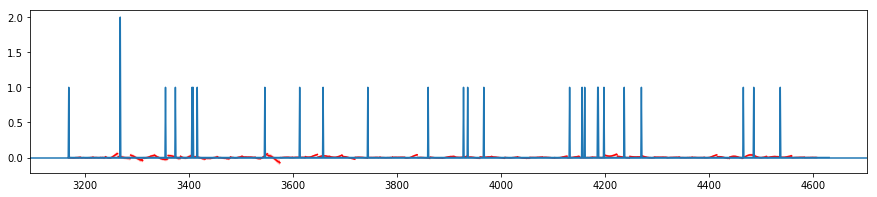

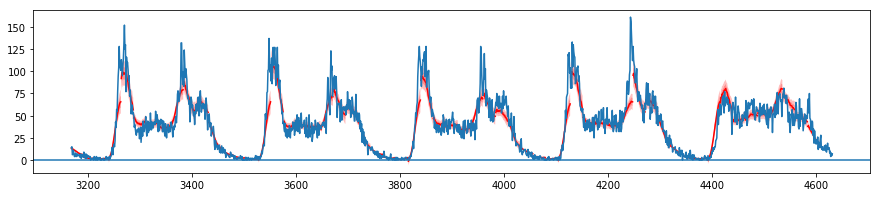

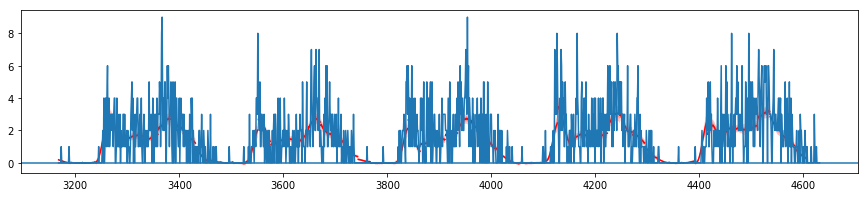

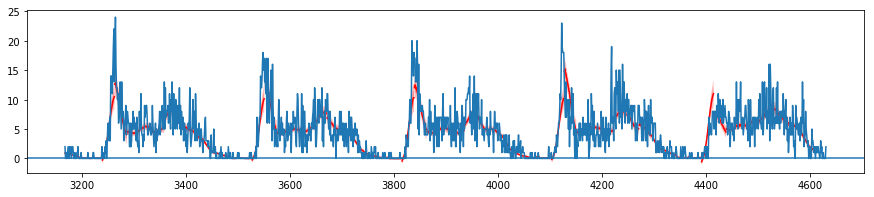

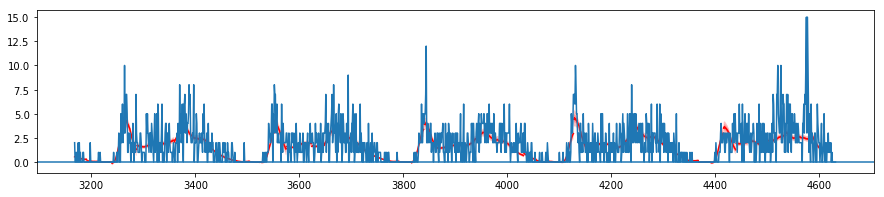

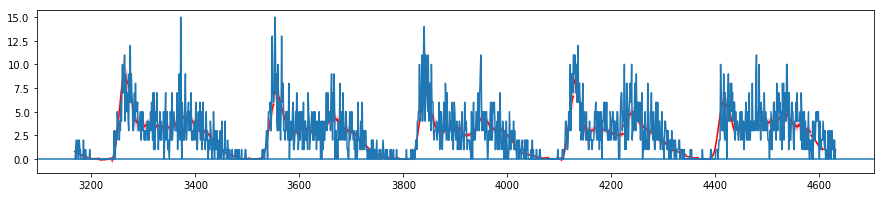

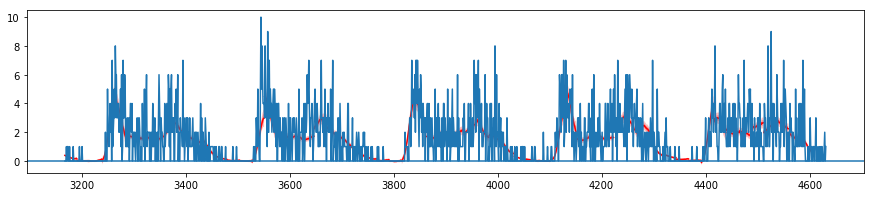

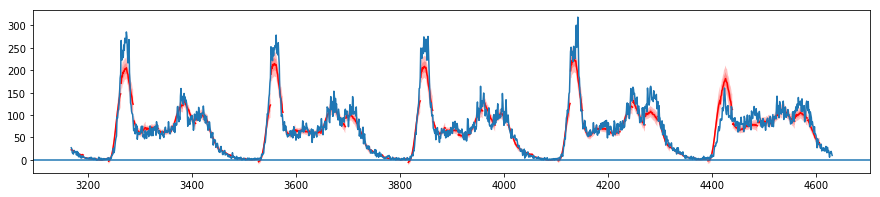

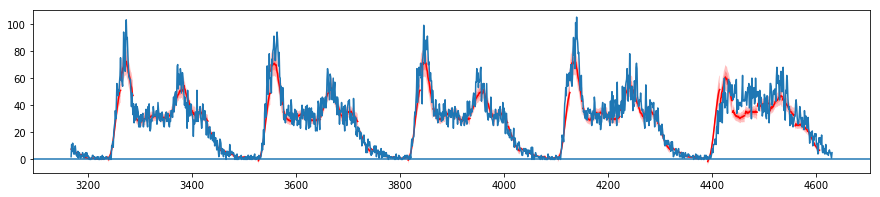

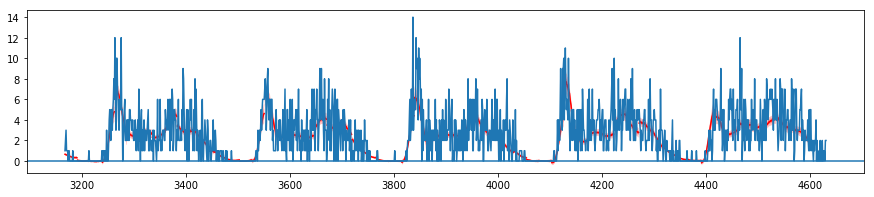

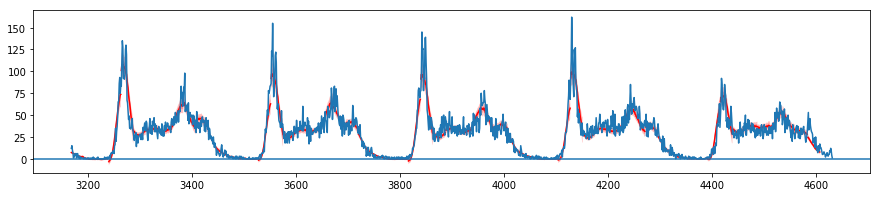

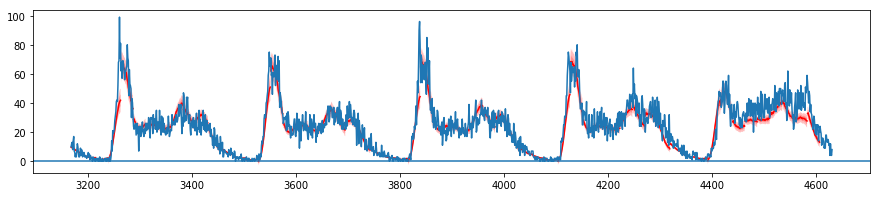

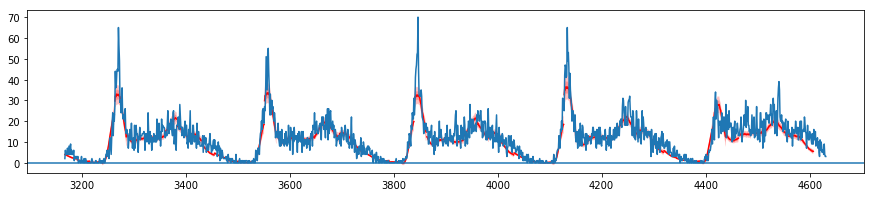

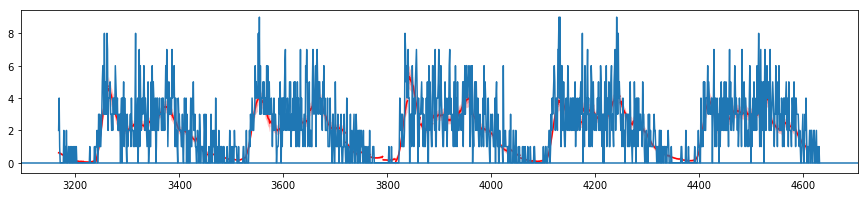

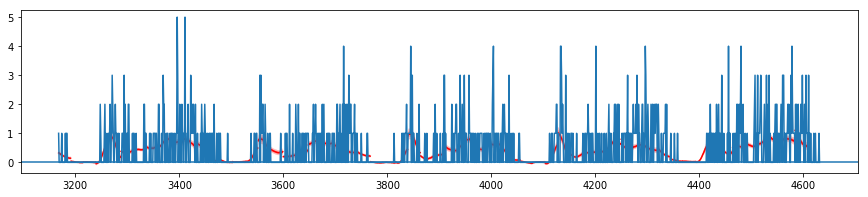

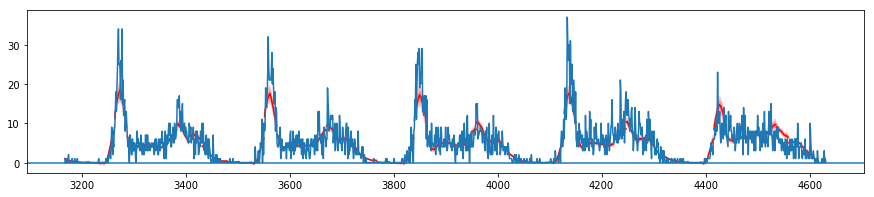

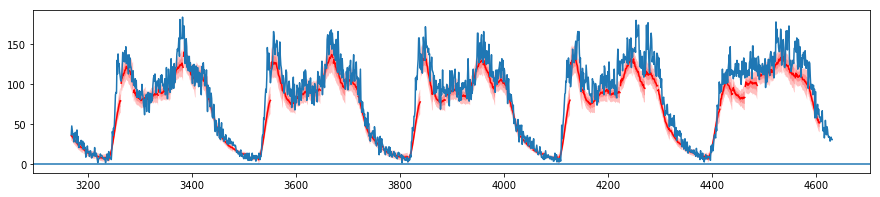

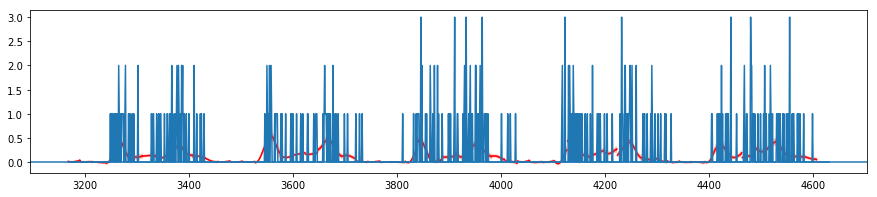

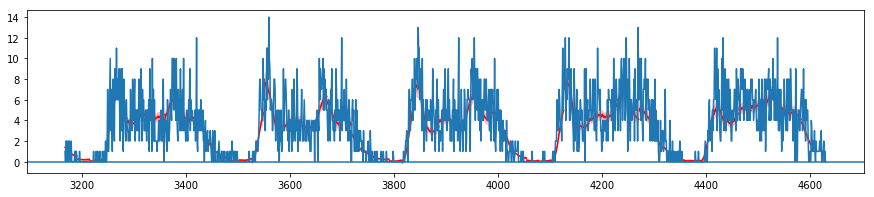

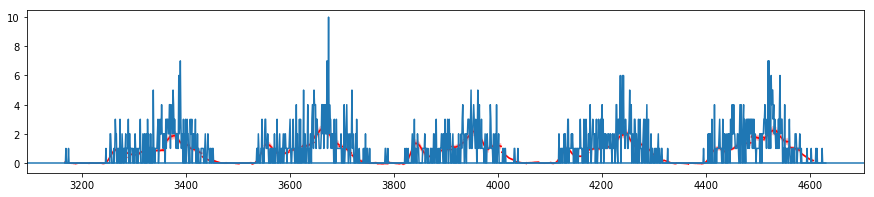

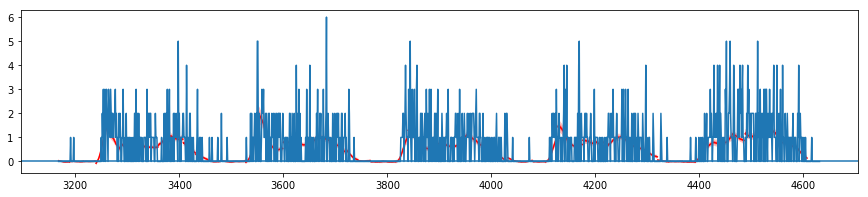

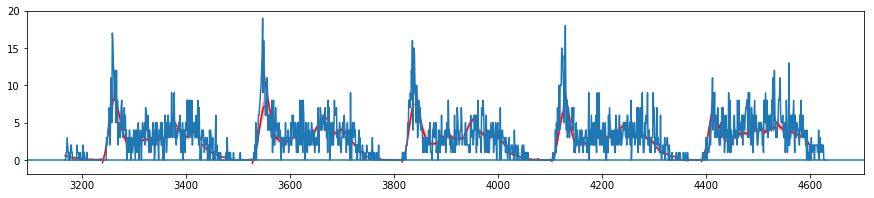

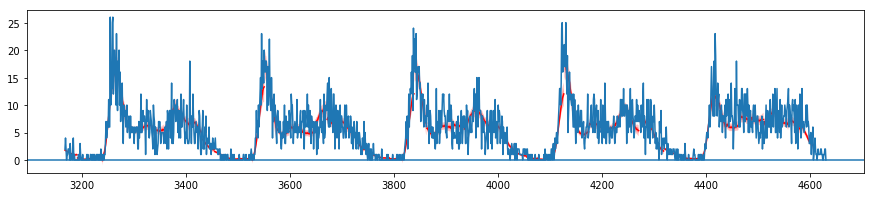

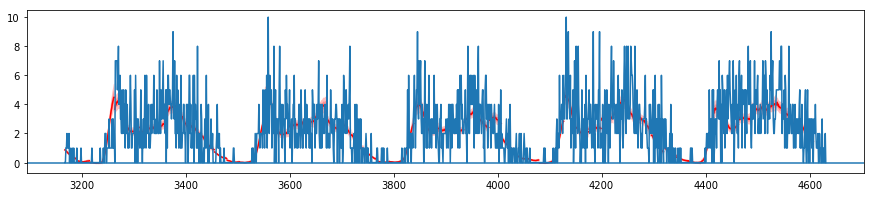

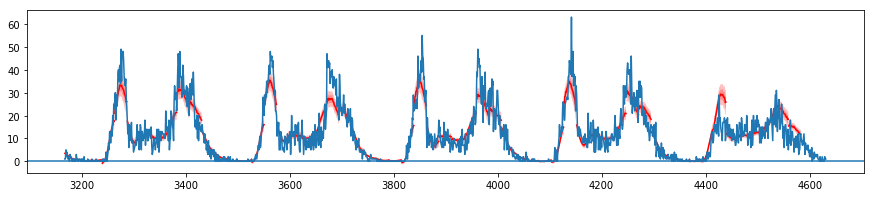

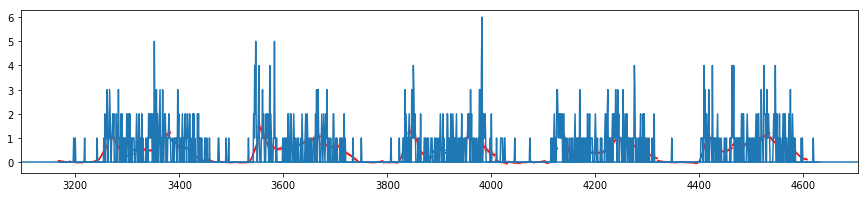

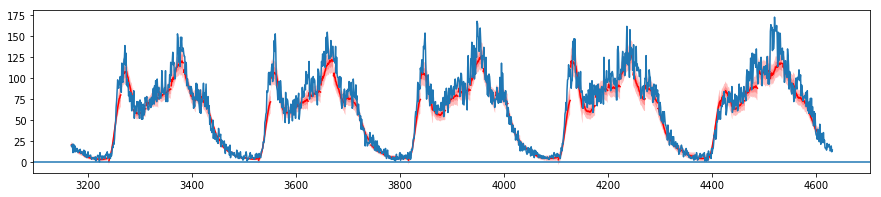

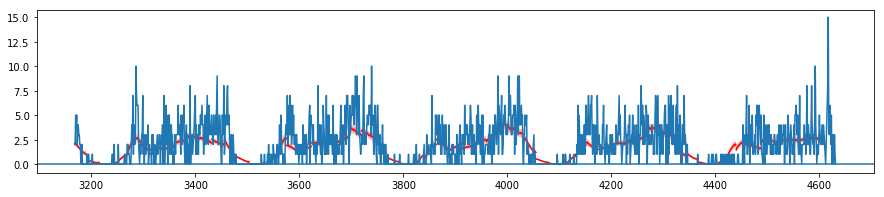

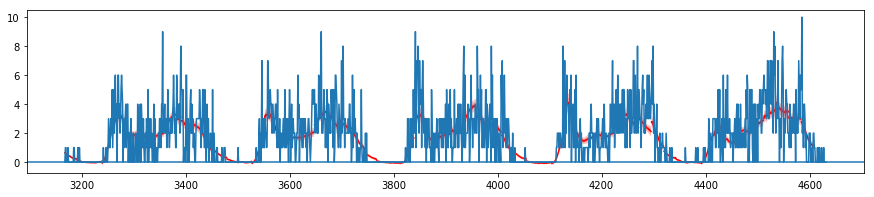

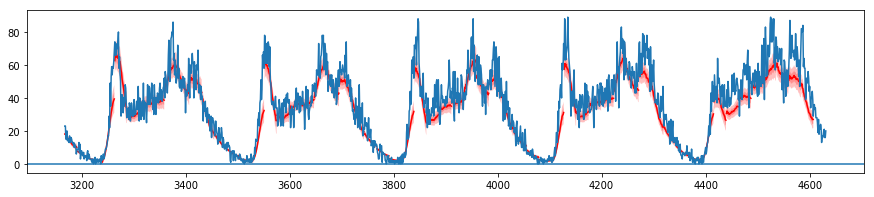

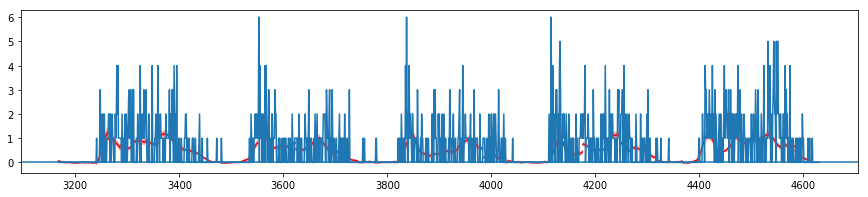

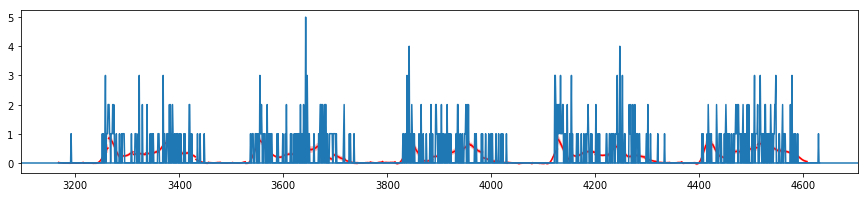

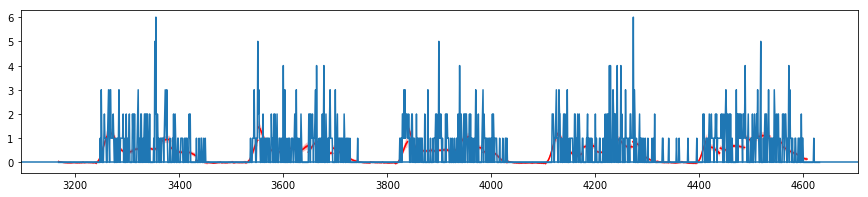

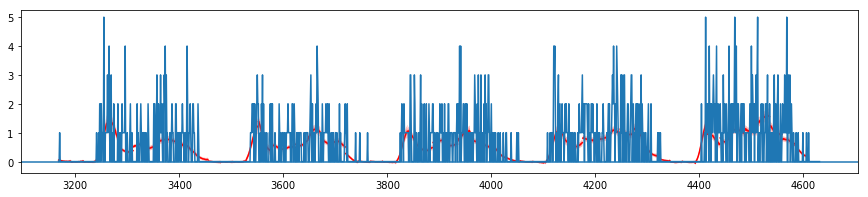

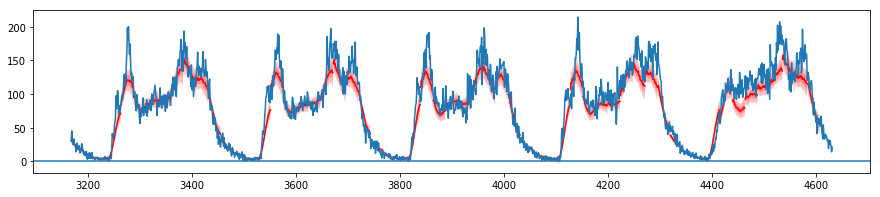

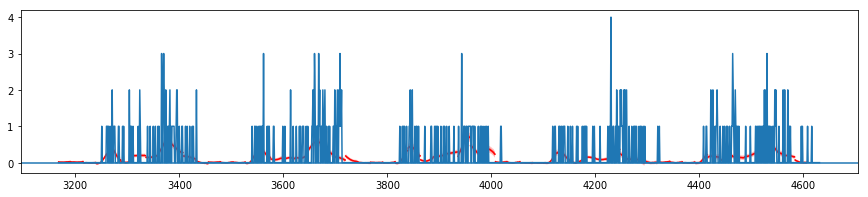

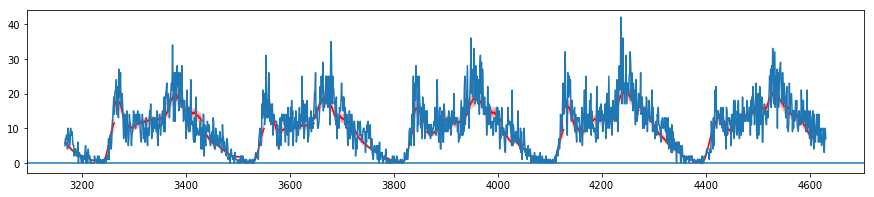

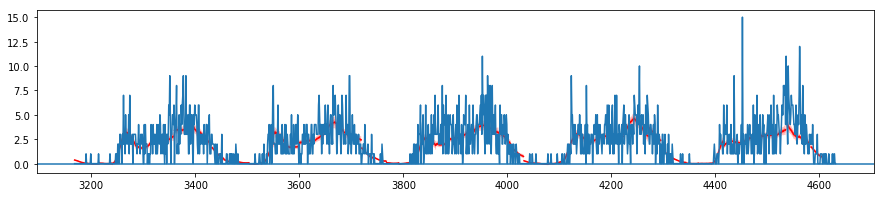

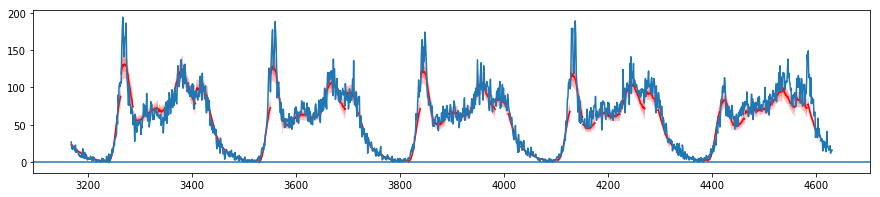

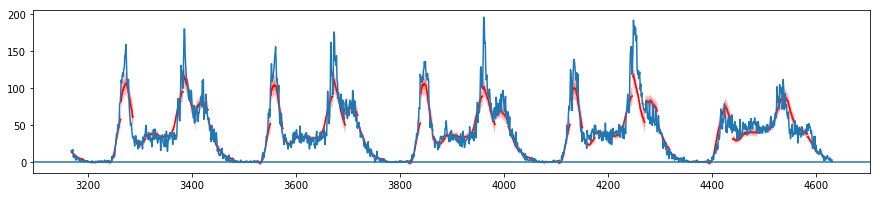

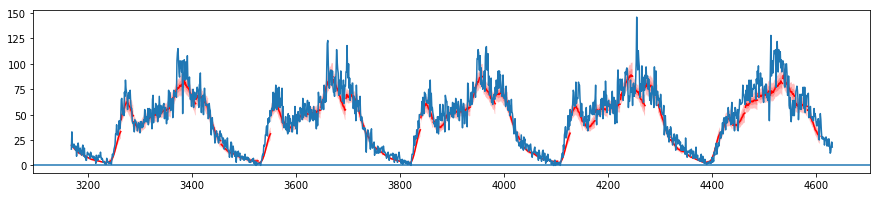

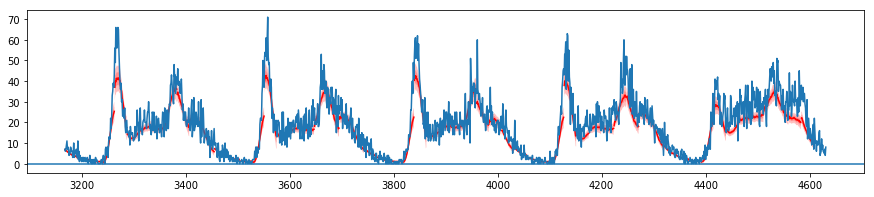

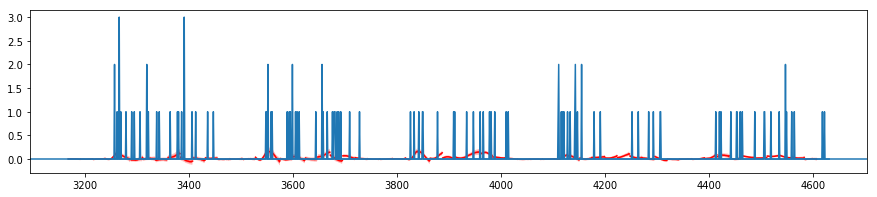

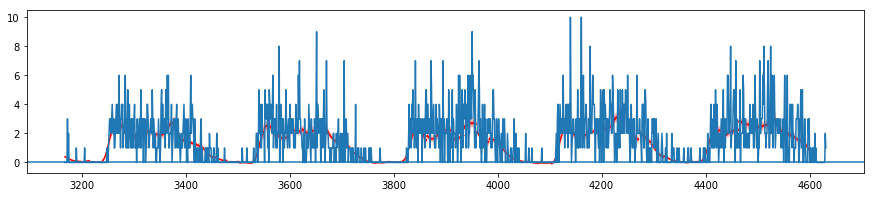

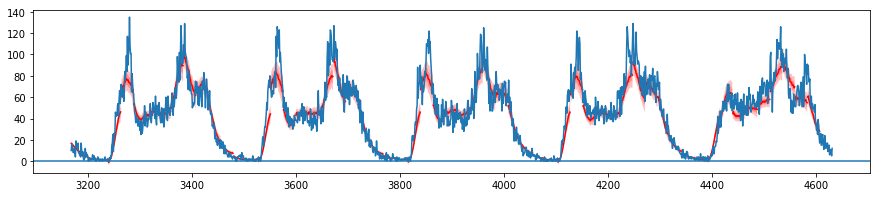

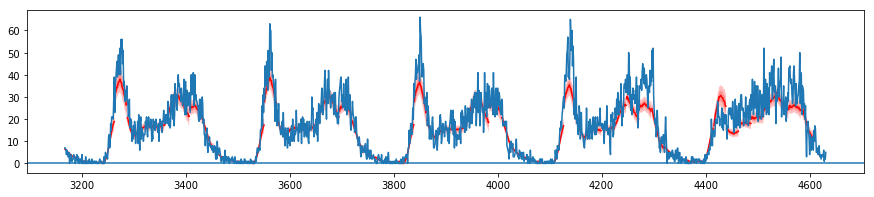

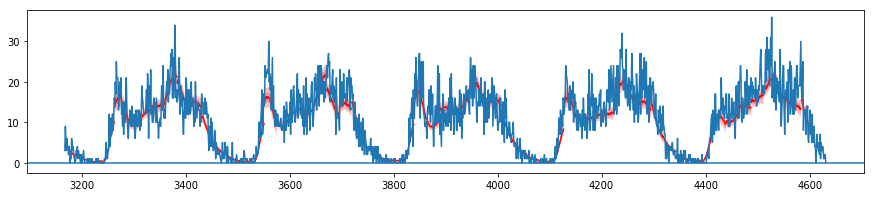

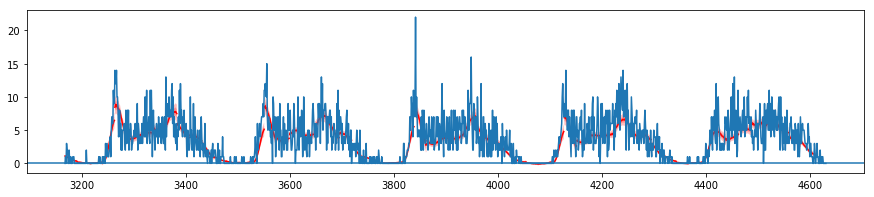

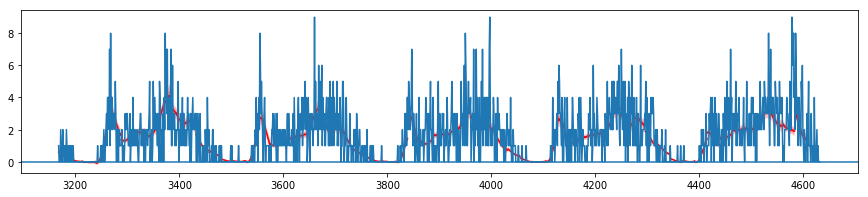

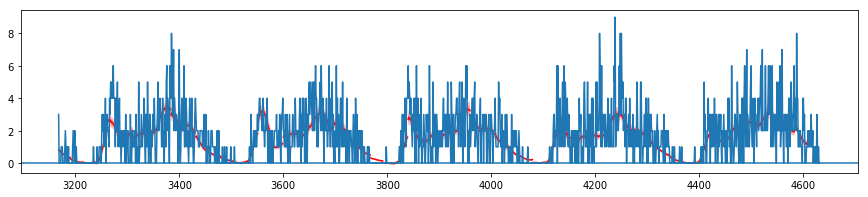

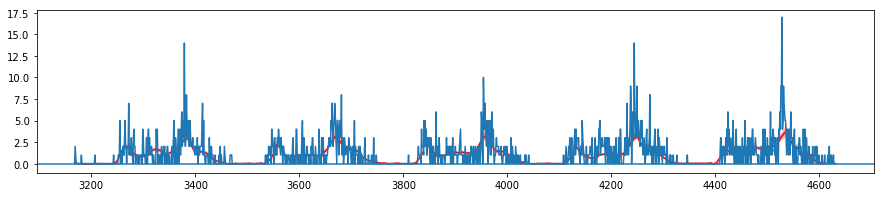

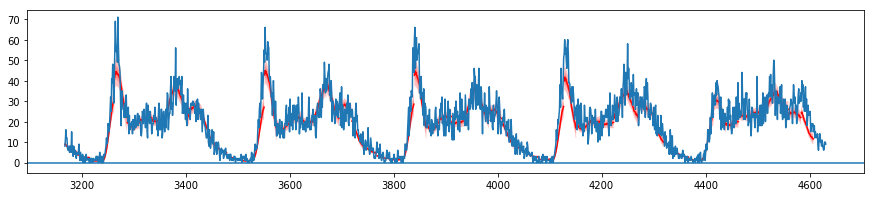

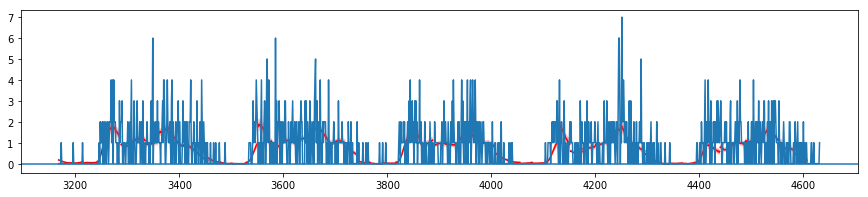

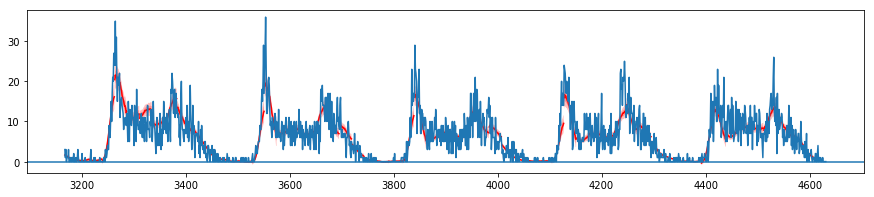

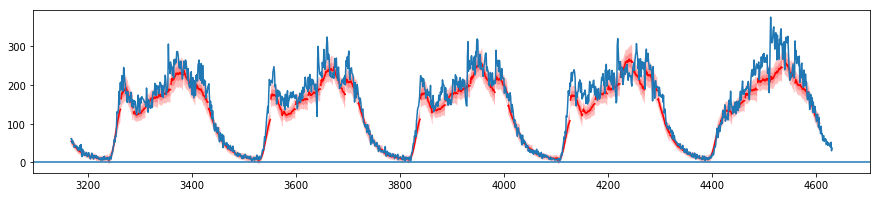

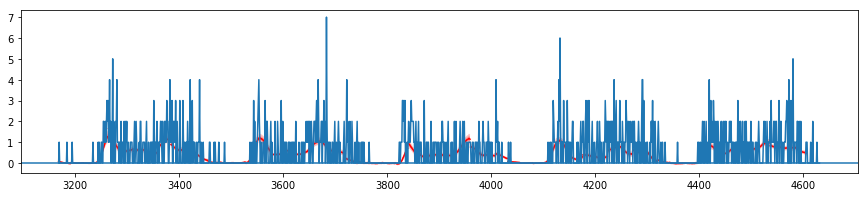

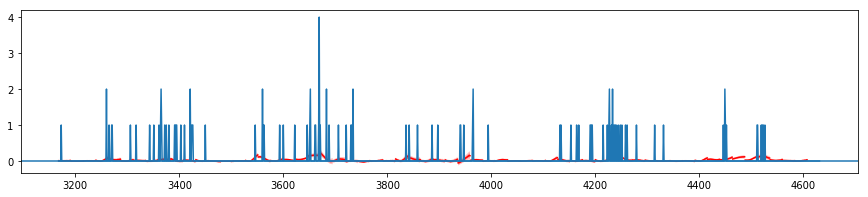

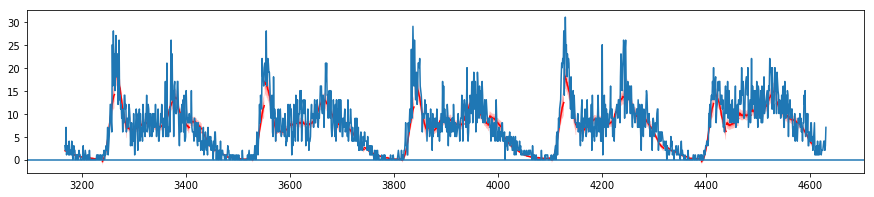

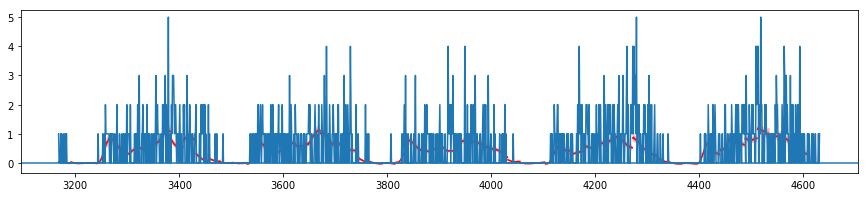

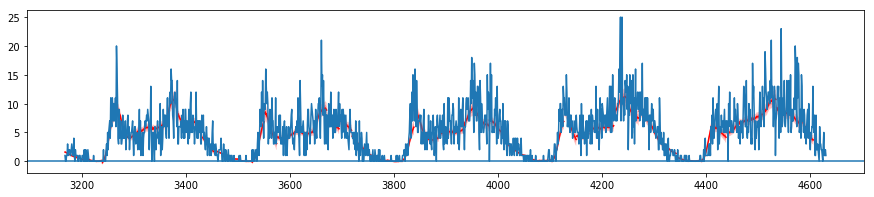

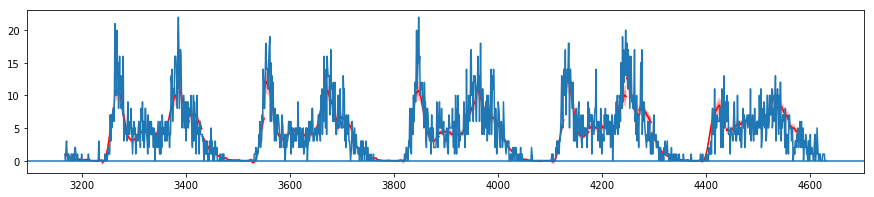

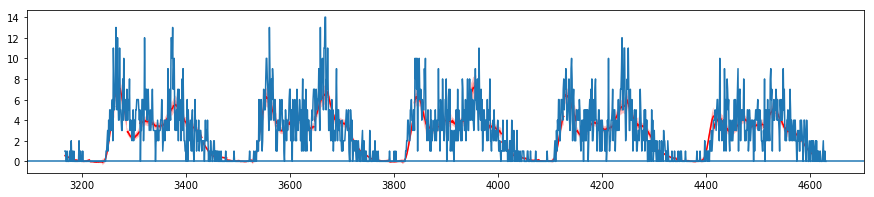

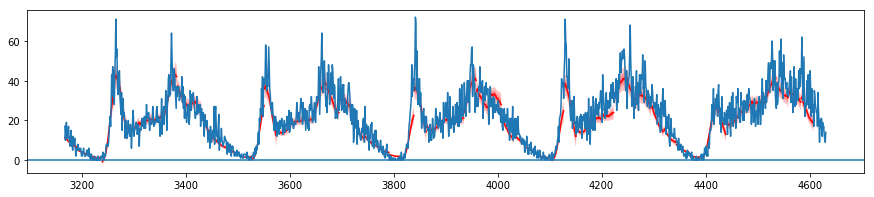

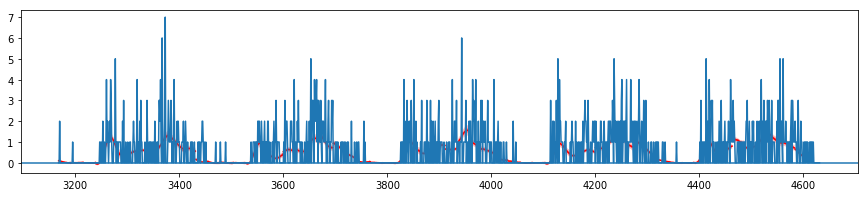

array([[[  3.74257909e-01,   4.89113234e-01,   4.17257453e-01, ...,
           6.17074450e-01,   5.83703888e-01,   5.65467524e-01],
        [  2.30592339e-01,   3.74440861e-01,   3.46900515e-01, ...,
           5.77251262e-01,   4.61653374e-01,   4.20109550e-01],
        [  4.86930240e-01,   1.00000000e+00,   5.77161213e-01, ...,
           4.82209747e-01,   4.69687860e-01,   4.85635531e-01],
        ..., 
        [  9.99996784e-01,   9.99998776e-01,   1.34863134e-08, ...,
           1.11839707e-01,   1.80566749e-01,   2.44786964e-01],
        [  9.99995885e-01,   1.25335036e-01,   9.99993941e-01, ...,
           3.67450111e-05,   9.11006884e-02,   3.85042915e-01],
        [  9.10945756e-03,   1.83084949e-02,   1.00000000e+00, ...,
           4.63506613e-01,   3.97339132e-01,   6.15982411e-01]],

       [[  1.36419315e-01,   2.48163320e-01,   1.88741344e-01, ...,
           1.65147715e-01,   1.67571207e-01,   2.17107569e-01],
        [  4.44430741e-01,   6.09693718e-01,   5.48250814e-0

In [30]:
predict(model, total_days=5,day=11,delta=24)